# DensePose-COCO dataset and SMPL model

This document demonstrates the localization of collected points on the SMPL model.


In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
import pickle

# Now read the smpl model.
with open('../DensePoseData/SMPL_MALE.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')
    Vertices = data['v_template']  ##  Loaded vertices of size (6890, 3)
    X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

num pts on picked person: (100,)
(100, 3)


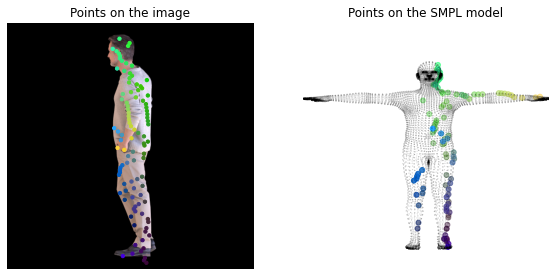

In [191]:
import os
import os.path as osp
import numpy as np
import cv2
import detectron.utils.densepose_methods as dp_utils
DP = dp_utils.DensePoseMethods()

img_dir = "/home/yxiu/Code/DC-PIFu/data/3dpeople_12views/10841_m_Will/render/"
out_dir = "/home/yxiu/Code/densepose/results"

img_file = os.listdir(img_dir)[2]
img_name = img_file.split(".")[0]

img_path = osp.join(img_dir, img_file)
inds_path = osp.join(out_dir, f"{img_name}_INDS.png")
iuv_path = osp.join(out_dir, f"{img_name}_IUV.png")

img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
INDS = cv2.imread(inds_path, 0)
IUV = cv2.imread(iuv_path)

pick_idx = 1    # PICK PERSON INDEX!

C = np.where(INDS == pick_idx)
num = np.linspace(0, C[0].shape[0]-1, 100).astype(np.int)
C = (C[0][num], C[1][num])
# C[0] is x-coords  np.array([23,  23,   24, ..])
# C[1] is y-coords  np.array([127, 128, 130, ..])
print('num pts on picked person:', C[0].shape)
IUV_pick = IUV[C[0], C[1], :]  # boolean indexing
IUV_pick = IUV_pick.astype(np.float)
IUV_pick[:, 1:3] = IUV_pick[:, 1:3] / 255.0
print(IUV_pick.shape)

collected_x = np.zeros(C[0].shape)
collected_y = np.zeros(C[0].shape)
collected_z = np.zeros(C[0].shape)

for i in range(IUV_pick.shape[0]):
    # Convert IUV to FBC (faceIndex and barycentric coordinates.)
    FaceIndex,bc1,bc2,bc3 = DP.IUV2FBC(IUV_pick[i, 0], IUV_pick[i, 1], IUV_pick[i, 2])
    # Use FBC to get 3D coordinates on the surface.
    p = DP.FBC2PointOnSurface( FaceIndex, bc1,bc2,bc3,Vertices )
    collected_x[i] = p[0]
    collected_y[i] = p[1]
    collected_z[i] = p[2]

fig = plt.figure(figsize=[15,5])

# color 
colors = np.concatenate((collected_x[:,None], 
                            collected_y[:,None], 
                            collected_z[:,None]),axis=1)
colors -= colors.min(0)
colors /= (colors.max(0)-colors.min(0))

# Visualize the image and collected points.
ax = fig.add_subplot(131)
ax.imshow(img)
ax.scatter(C[1], C[0], 11, c=colors)
plt.title('Points on the image')
ax.axis('off')

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(132, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')

ax.scatter(collected_z,  collected_x, collected_y, s=25, c=colors)
smpl_view_set_axis_full_body(ax)
plt.title('Points on the SMPL model')

plt.show()


In [189]:
collected_y.min()

-1.1928510183139032